In [1]:
# https://www.kaggle.com/code/armandodelahoya/walmart-sales-forecasting-prophet-model
# https://www.kaggle.com/code/akritiupadhyayks/walmart-sales-forecasting-by-prophet-and-xgboost

## Imports

In [2]:
import pandas as pd
from datetime import datetime
from zipfile import ZipFile

#matplotlib configuration
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.family'] = 'Trebuchet MS'

matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


#Metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [3]:
# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

#plotly configuration
import plotly.offline as py

In [5]:
df = pd.read_csv('data/data_eda.csv')

In [6]:
df.head()

,Date,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Type,Size
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315
1,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315
2,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315
3,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315
4,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315


In [7]:
df.rename(columns = {'Weekly_Sales': 'y', 'Date': 'ds'}, inplace = True)
df.head()

,ds,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,y,Type,Size
0,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,1,24924.50,A,151315
1,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,2,50605.27,A,151315
2,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,3,13740.12,A,151315
3,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,4,39954.04,A,151315
4,2010-02-05,1,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,5,32229.38,A,151315


In [8]:
df['ds'] = pd.to_datetime(df['ds'])

In [9]:
df.dtypes

ds              datetime64[ns]
Store                    int64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
IsHoliday                 bool
Dept                     int64
y                      float64
Type                    object
Size                     int64
dtype: object

In [31]:
merged_df = df[['ds','y','Temperature','Fuel_Price','CPI','Unemployment', 'Dept', 'Size', 'Store']]

In [29]:
merged_df.head()

,ds,y,Temperature,Fuel_Price,CPI,Unemployment,Dept,Size,Type,Store
0,2010-02-05,24924.50,42.31,2.572,211.096358,8.106,1,151315,A,1
1,2010-02-05,50605.27,42.31,2.572,211.096358,8.106,2,151315,A,1
2,2010-02-05,13740.12,42.31,2.572,211.096358,8.106,3,151315,A,1
3,2010-02-05,39954.04,42.31,2.572,211.096358,8.106,4,151315,A,1
4,2010-02-05,32229.38,42.31,2.572,211.096358,8.106,5,151315,A,1


In [32]:
from prophet import Prophet
m = Prophet(daily_seasonality=True)
m.add_regressor('Temperature')
m.add_regressor('Fuel_Price')
m.add_regressor('CPI')
m.add_regressor('Unemployment')
m.add_regressor('Dept')
m.add_regressor('Size')
# m.add_regressor('Type')
m.add_regressor('Store')
model_fit = m.fit(merged_df)

17:42:00 - cmdstanpy - INFO - Chain [1] start processing
17:42:32 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
forecast = model_fit.predict(merged_df)
forecast[['ds','yhat','Temperature','Fuel_Price','CPI','Unemployment', 'Dept', 'Size', 'Store']].tail()

,ds,yhat,Temperature,Fuel_Price,CPI,Unemployment,Dept,Size,Store
421565,2012-10-26,24703.764076,-1517.686296,324.122666,1172.574734,948.792741,526.932339,7376.745802,733.986418
421566,2012-10-26,24814.938680,-1517.686296,324.122666,1172.574734,948.792741,638.106943,7376.745802,733.986418
421567,2012-10-26,25037.287889,-1517.686296,324.122666,1172.574734,948.792741,860.456152,7376.745802,733.986418
421568,2012-10-26,12512.276192,-2115.735307,267.356245,-821.136127,715.983924,-4475.924853,5303.189462,-1499.752824
421569,2012-10-26,17026.918921,-143.446015,428.605789,-618.600102,-286.635231,5974.487949,-1646.930709,-1818.858430


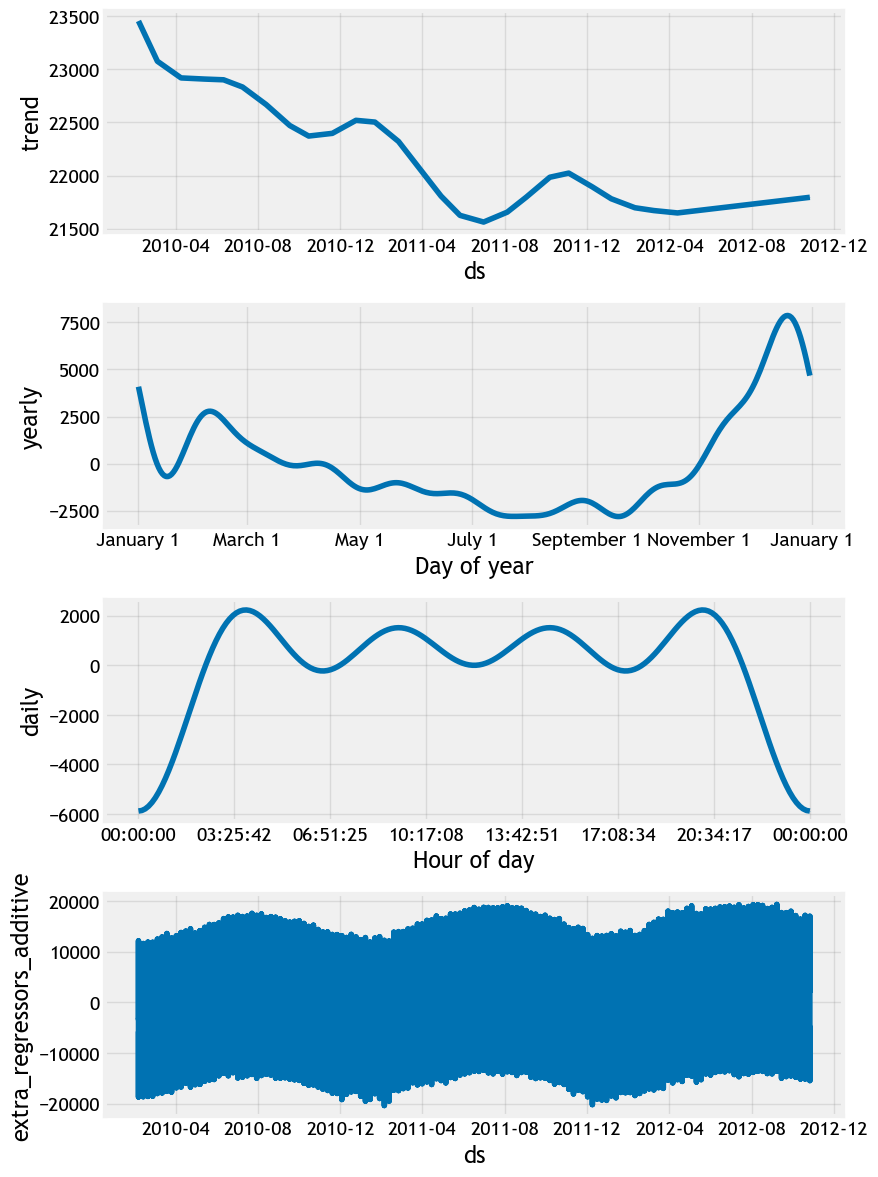

In [34]:
model_fit.plot_components(forecast);

In [35]:
predictions = forecast[['ds','yhat']]
predictions = predictions.rename(columns = {'ds':'Date','yhat':'Weekly_Sales'})
predictions.head()

,Date,Weekly_Sales
0,2010-02-05,14428.198387
1,2010-02-05,7875.610257
2,2010-02-05,7986.784861
3,2010-02-05,8097.959465
4,2010-02-05,8209.134070


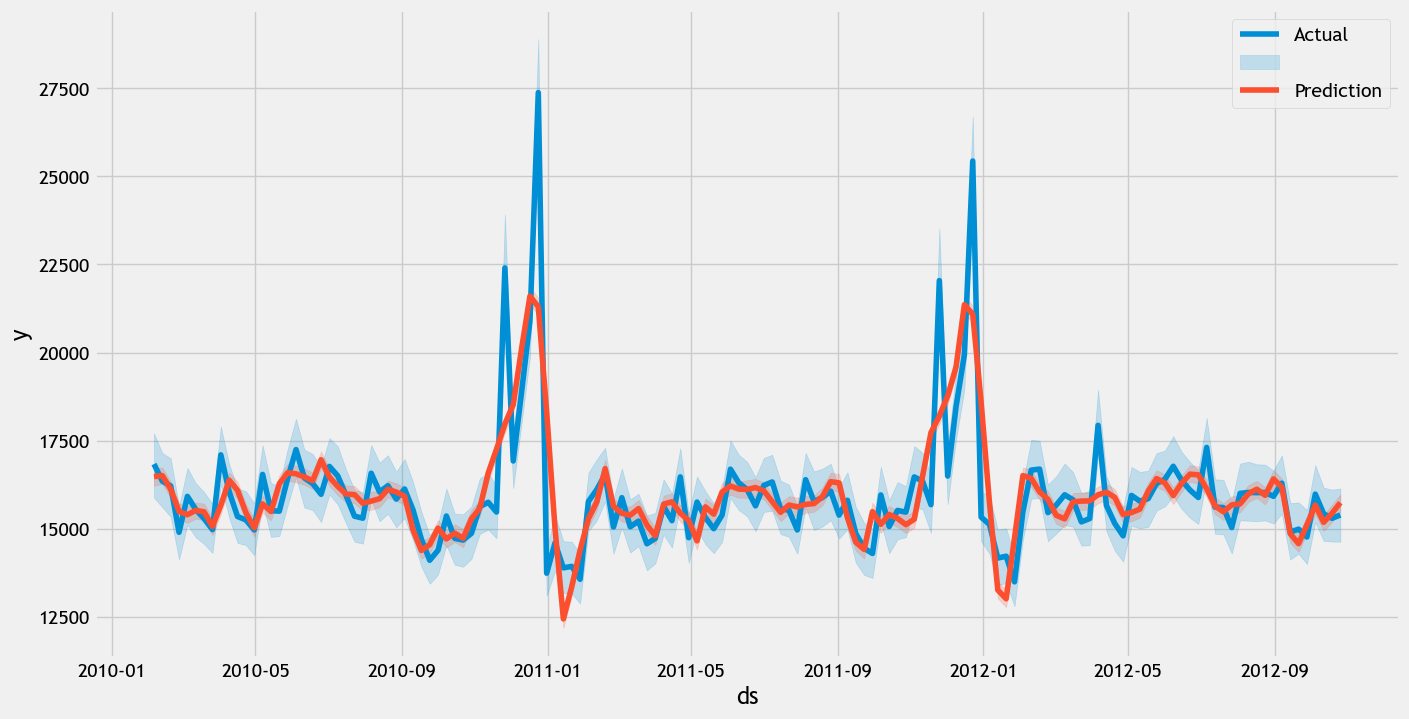

In [36]:
plt.subplots(figsize = (15,8))
sns.lineplot(time_data,x = 'ds',y='y',legend='full')
sns.lineplot(predictions,x = 'Date',y = 'Weekly_Sales',legend='full')
plt.legend(labels = ['Actual','','Prediction'])
plt.ticklabel_format(useOffset=False,style='plain',axis='y')
plt.show()

In [37]:
predictions['Date'] = pd.to_datetime(predictions['Date'])
predictions['Year'] = predictions['Date'].dt.year
predictions['Month'] = predictions['Date'].dt.month
predictions['MonthName'] = predictions['Date'].dt.month_name()
# predictions['Week'] = predictions['Date'].dt.week

In [ ]:
predictions.head()


In [ ]:
x_time  = predictions.drop(columns=['Date','Weekly_Sales','MonthName'])
y_time = predictions[['Weekly_Sales']]

In [ ]:
x_time_train,x_time_test,y_time_train,y_time_test = train_test_split(x_time,y_time,test_size=0.2,random_state=20)

## Submission

In [ ]:
submission1 = pd.read_csv('data/sampleSubmission.csv')

In [ ]:
submission1['Weekly_Sales'] = test_preds

In [ ]:
submission1.set_index('Id', inplace=True)

In [ ]:
submission1.to_csv('data/submission2_prophet.csv')